# Installatin
> ####  [Media pipe](https://google.github.io/mediapipe/solutions/face_mesh.html) is an open-source cross-platform framework for building multimodel machine learning pipelines.


In [1]:
!pip install mediapipe

^C


### Required modules

In [49]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso,ElasticNet
from sklearn.model_selection import GridSearchCV
import xgboost
from xgboost import XGBRegressor

### Load the libraries

In [26]:
import mediapipe as mp
import cv2
import time
import numpy as np
import pandas as pd
import os 
from os import path 
import scipy.io as sio  # to read the mat file in the data 
import math 
from math import cos , sin 
from matplotlib import pyplot as plt
%pylab inline
%matplotlib inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### In the above snippet of code, we have first imported the necessary libraries that will help in creating the dataset. Then in the next lines, we are importing the modules required to extract key points and their draw utils. 
>>  The FaceMesh object from the Mediapipe library. This object will detect faces and also detect keypoints from one or more faces.

>>  The VideoCapture object from the OpenCV library. This object will be used for retrieving images from the webcam. We set a parameter on the object with 0 for retrieving images from the webcam.





In [5]:
mp_face_mesh = mp.solutions.face_mesh
#face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True,refine_landmarks=True)
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)
#face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1,refine_landmarks=True,min_detection_confidence=0.5)
cap = cv2.VideoCapture(0) 

## this notbook was created in jupyter if you are using colab notice that 
!!!!!!!!!!!!! Google colab crashes if you try to display image using cv2.imshow() instead import from g::oogle.colab.patches import cv2_imshow and display using cv2_imshow(<image>)

In [6]:
from google.colab.patches import cv2_imshow    


ModuleNotFoundError: No module named 'google.colab'

## this function takes the image path and return it's keypoints 


In [111]:
def get_results(image): 

   # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)

      # To improve performance
    image.flags.writeable = False

      # Get the results [it contains all the landmarks and thire dimentions  ]
    results = face_mesh.process(image)

      # To improve performance
    image.flags.writeable = True

      # Convert the color space from RGB to BGR
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
     # check if the landmarks are extracted or not 
    if (results.multi_face_landmarks) != None:
        return(results,image)
    else:
        return(None , None )  


In [34]:
## this function takes the image path and return it's keypoints 
def get_results_img(image): 
      # Read the image 

  image = cv2.imread(image)
  #original = cv2.imread("face_pase/AFLW2000/image00002.jpg")
  #image = cv2.resize(image,(original.shape[1],original.shape[0]), interpolation = cv2.INTER_AREA)
      # Convert the color space from BGR to RGB
  #image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      # To improve performance
  image.flags.writeable = False

      # Get the results [it contains all the landmarks and thire dimentions  ]
  results = face_mesh.process(image)

      # To improve performance
  image.flags.writeable = True

      # Convert the color space from RGB to BGR
  #image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  if (results.multi_face_landmarks) != None:
    return(results,image)
  else:
    return(None , None )  
   

In [19]:
def creat_dataSet (results):
# creat empty dictionry to store points in it after appending them in the dataframe
    data_points_x = dict()
    data_points_y = dict()

## loop to get points dimentions (x,y)
    for key_point in results.multi_face_landmarks:

        for idx,landmark in enumerate(key_point.landmark):
            if idx == 4:
                nose_dx = (landmark.x)*image.shape[1]
                nose_dy = (landmark.y)*image.shape[0]
            x = landmark.x
            y = landmark.y

            ## append dimentions in the data frame 
            data_points_x[f"{idx}"+"_x"] = x 
            data_points_y[f"{idx}"+"_y"] =  y
   #calculate distance between head and chin
    dist_x = data_points_x["152_x"]-data_points_x["10_x"]
    dist_y = data_points_y["152_y"]-data_points_y["10_y"]
    
    distance = (dist_x**2 + dist_y**2)**0.5
    # normalized to the face position inside the images and center them around the nose 
    center_x =  data_points_x["4_x"]
    center_y =  data_points_y["4_y"]
    
    for i , j in zip(data_points_x,data_points_y):
        data_points_x[i] = (data_points_x[i] - center_x)/distance
        data_points_y[j] = (data_points_y[j] - center_y)/distance
    # conactinate bet two dic to append them in data set 
    data_points_x.update(data_points_y)
    data_points = data_points_x 

    return  data_points ,image ,nose_dx,nose_dy



### This function takes the predicted euler angles and the center point and draw the axes  

In [57]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 70):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)
    return img

In [9]:
import warnings
warnings.filterwarnings('ignore')

# **MODEL SELECTION**

Now we have created our dataset, we just have to pick a machine-learning algorithm to classify the poses. In this step, we will take an image, run the face mesh model (that we used earlier for creating the dataset) to get the key points of the person present in that image, and run our model on that test case. The model is expected to give the correct results with a high confidence score. I am going to use several models from the sklearn library then choose the best one to perform the Regression task.

### read the stored data 

In [10]:
face_data_pitch = pd.read_csv("face_pase/all_head_badr_trick.csv")
face_data_pitch.drop(columns="Unnamed: 0",inplace = True)

### Building a performance-driven model is not a very easy task. It involves refining our model again and again until we get the desired outcome.
 We will use some regression model and fine tune them as possiple 

## First split data to train and test 

In [11]:
features = face_data_pitch.iloc[:,0:-3]
labels = face_data_pitch.iloc[:,-3:]
X_train, X_test, y_train, y_test = train_test_split( features, labels, test_size=0.2, random_state=42)

### 1: **USING SVR** 
**We will Tune the parameter manually**


In [12]:
## FOR PITCH ANGLE 
def pitch_svr(model):
 # scaler_pitch = StandardScaler()
    scaler_pitch = RobustScaler()
    model_pitch = model 

    # scal features 
    scaled_train_features = scaler_pitch.fit_transform(X_train)
    scaled_test_features = scaler_pitch.transform(X_test)

    # fit train data 
    model_pitch.fit(X_train, y_train["pitch"])
    y_pred = model_pitch.predict(X_test)
    # print train & test score 
    print("pitch training score: ",model_pitch.score(X_train, y_train["pitch"], sample_weight=None))
    print("pitch testing score: ",model_pitch.score(X_test, y_test["pitch"], sample_weight=None))
    print(mean_squared_error(y_test["pitch"], y_pred))
    return model_pitch,scaler_pitch
      


In [13]:
model_pitch,scaler_pitch = pitch_svr(SVR( C=10 , coef0=1, epsilon=0.01 ,kernel='rbf'))

pitch training score:  0.1845068294011729
pitch testing score:  0.742532653957144
0.018792290561893323


In [17]:
## FOR yaw ANGLE 
def yaw_svr(model):
  scaler_yaw = StandardScaler()
  model_yaw = model

  # scal features 
  scaled_train_features = scaler_yaw.fit_transform(X_train)
  scaled_test_features = scaler_yaw.transform(X_test)

  # fit train data 
  model_yaw.fit(X_train, y_train["yaw"])

  y_pred = model_yaw.predict(X_test)
  # print train & test score 
  print("yaw training score: ",model_yaw.score(X_train, y_train["yaw"], sample_weight=None))
  print("yaw testing score: ",model_yaw.score(X_test, y_test["yaw"], sample_weight=None))
  print(mean_squared_error(y_test["yaw"], y_pred))
  return model_yaw,scaler_yaw
      

In [18]:
model_yaw,scaler_yaw= yaw_svr(SVR( C=100, coef0=1, epsilon=0.01, kernel='rbf'))

yaw training score:  0.8829778647746913
yaw testing score:  0.9500287068638777
0.012648494313701398


In [19]:
## FOR roll ANGLE 
def roll_svr(model):
  scaler_roll = StandardScaler()
  model_roll = model
  # scal features 
  scaled_train_features = scaler_roll.fit_transform(X_train)
  scaled_test_features = scaler_roll.transform(X_test)

  # fit train data 
  model_roll.fit(X_train, y_train["roll"])

  # print train & test score 
  y_pred = model_roll.predict(X_test)
  # print train & test score 
  print("pitch training score: ",model_roll.score(X_train, y_train["roll"], sample_weight=None))
  print("pitch testing score: ",model_roll.score(X_test, y_test["roll"], sample_weight=None))
  print(mean_squared_error(y_test["roll"], y_pred))
  return(model_roll,scaler_roll)
     

In [20]:
model_roll,scaler_roll = roll_svr(SVR(C=150, coef0=1, epsilon=0.001, kernel='rbf'))

pitch training score:  0.426423342307952
pitch testing score:  0.8243169256031492
0.017701790254539714


#### It's not easy to tune each model manually so we will use MultiOutput model

## using MultiOutput model 

In [14]:
# define base model
model = SVR(kernel='rbf', C=0.1,coef0=1) 
scaler_all = RobustScaler()

# define the direct multioutput model
all_svr = MultiOutputRegressor(model)
all_svr.fit(X_train, y_train)
y_pred_test = all_svr.predict(X_test)
y_pred_train = all_svr.predict(X_train)
print("Train_MSE:", mean_squared_error(y_train, y_pred_train))
print("Test_MSE:", mean_squared_error(y_test, y_pred_test))

Train_MSE: 0.2493374090043702
Test_MSE: 0.017760503011583547


### 2: **XGBoost**

#### XGBoost algorithm provides large range of hyperparameters.
##### (check this for more info)[https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook#5.-Results-and-Conclusion-]
#### We will tune three of them 


    >> **eta** [default=0.3, alias: learning_rate]
     Step size shrinkage used in update to prevents overfitting. After each boosting step, we        can directly get the weights of new features, and eta shrinks the feature weights to make        the boosting process more conservative.

    >> **gamma** [default=0, alias: min_split_loss]
    Minimum loss reduction required to make a further partition on a leaf node of the tree. The     larger gamma is, the more conservative the algorithm will be.

    >> **lambda** [default=1, alias: reg_lambda]
    L2 regularization term on weights. Increasing this value will make model more conservative.


In [98]:
""" {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "alpha":[0.1 , 0.5 , 1]
 }"""
model  = XGBRegressor(random_state=42,gamma=500,learning_rate=0.15)
all_XGB = MultiOutputRegressor(model)
#parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}
#all_ridge=GridSearchCV(ridge,parameters,scoring='neg_mean_squared_error',cv=5)

all_XGB.fit(X_train, y_train)

# Generate predictions for testing data
print(f"training score: {all_XGB.score(X_train, y_train)}")
print(f"testing score: {all_XGB.score(X_test, y_test)}")
y_pred = all_XGB.predict(X_test)
mean_squared_error(y_test, y_pred)

training score: 0.22529615737986555
testing score: -0.28109922652599273


0.15558768953721774

### 3:**lasso**

In [104]:
lasso = Lasso(alpha=0.01, tol = 1e-6)
all_model_lasso = MultiOutputRegressor(lasso)
all_model_lasso.fit(X_train, y_train)
# Generate predictions for testing data
y_pred_test = all_model_lasso.predict(X_test)
y_pred_train = all_model_lasso.predict(X_train)
print("Train_MSE:", mean_squared_error(y_train, y_pred_train))
print("Test_MSE:", mean_squared_error(y_test, y_pred_test))

Train_MSE: 0.2483124970706434
Test_MSE: 0.02061539585165147


### 4:**ElasticNet**

In [105]:
ElasticNet_model = ElasticNet(alpha=0.01)
all_model_ElasticNet = MultiOutputRegressor(ElasticNet_model)
all_model_ElasticNet.fit(X_train, y_train)
# Generate predictions for testing data
y_pred_test = all_model_ElasticNet.predict(X_test)
y_pred_train = all_model_ElasticNet.predict(X_train)
print("Train_MSE:", mean_squared_error(y_train, y_pred_train))
print("Test_MSE:", mean_squared_error(y_test, y_pred_test))

Train_MSE: 0.24413554833052467
Test_MSE: 0.019405418582349968


## Model Evaluation in image 

In [109]:
results , image = get_results_img("face_pase/test_images/leftt.jpg")
axis,img,tdx,tdy = creat_dataSet(results)
axis_df = pd.DataFrame()
axis_df = axis_df.append(axis,ignore_index=True)


### 1:SVR

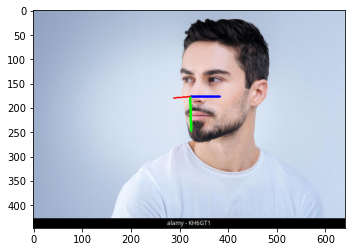

In [89]:
pre = all_svr.predict(axis_df)
image = draw_axis(img , pre[0][0] , pre[0][1]  , pre[0][2]  , tdx, tdy)
plt.imshow(image)
plt.show()

### 2:XGboost

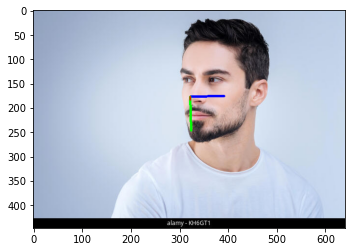

In [101]:
pre = all_ridge.predict(axis_df)
image = draw_axis(img , pre[0][0] , pre[0][1]  , pre[0][2]  , tdx, tdy)
plt.imshow(image)
plt.show()

### 3:LASSO

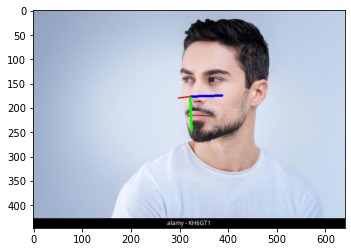

In [93]:
pre = all_model_lasso.predict(axis_df)
image = draw_axis(img , pre[0][0] , pre[0][1]  , pre[0][2]  , tdx, tdy)
plt.imshow(image)
plt.show()

### ElasticNet

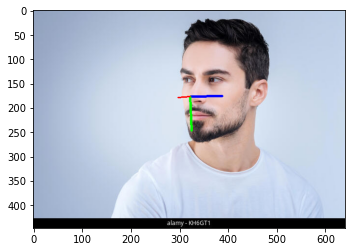

In [95]:
pre = all_model_ElasticNet.predict(axis_df)
image = draw_axis(img , pre[0][0] , pre[0][1]  , pre[0][2]  , tdx, tdy)
plt.imshow(image)
plt.show()

### After many trails for tunning, XGBoost was the worst one It took alot of time for fitting and despite it's low MSE, it's performance in image was't good. The other three models got almost the same results.

In [106]:
# save model
import pickle
with open('SVR_all.pkl', 'wb') as file:
        pickle.dump(all_svr, file)

### SVR evaluation in video 

In [108]:
#load model 
loaded_model = pickle.load(open("SVR_all.pkl", 'rb'))

In [112]:
import cv2
i=1

cap = cv2.VideoCapture("face_pase/test_images/final.mp4")
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = cap.get(cv2.CAP_PROP_FPS)
out = cv2.VideoWriter('outpy2.avi',cv2.VideoWriter_fourcc('M','J','P','G'), fps, (frame_width,frame_height))

while cap.isOpened():
    ret, image = cap.read()
    if ret:  
       # get the landmarks by calling get_results function   
      results , image = get_results(image)
        
      if results !=None:
        # creat dataframe each columns is (x,y) of face landmarks 
        axis,img,tdx,tdy = creat_dataSet(results)
        features = pd.DataFrame()
        features = features.append(axis,ignore_index=True)
        
        # get expected eualr angles     
        pre =loaded_model.predict(features) 
        
        # get the image with axis drown in it 
        out_img = draw_axis(img , pre[0][0] , pre[0][1]  , pre[0][2]  , tdx, tdy)
        
        # save the image in the video 
        out.write(out_img)
        
    else:
      break

    cv2.waitKey(1) & 0xff

cv2.destroyAllWindows()
cap.release()
out.release()